In [1]:
# Import Packages and Libraries needed for the project
import pandas as pd
import numpy as np

# for data processing
import requests
import json

# for Geospatial data
import geopandas as gpd 

# for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
def a_load_data(url):
    # Load GeoPandas data from OpenData.Minneapolis.Gov Active Rental Licenses in the City of Minneapolis
    # https://opendata.minneapolismn.gov/datasets/cityoflakes::active-rental-licenses/about
    response = requests.get(url)
    data = json.loads(response.text)
    # since the data contains nested dictionaries we need to flatten the data from the outer features key
    data2 = pd.json_normalize(data['features'])
    # Rename the nested dictionary keys of geometry and  properties columns by removing geometry and properties.
    data2.columns = data2.columns.str.replace('geometry.', '')
    data2.columns = data2.columns.str.replace('properties.', '')
    return data2
    

In [3]:
# Retreive Businss License Data from opendata.minneapolis.gov
business_license_url = "https://services.arcgis.com/afSMGVsC7QlRK1kZ/arcgis/rest/services/Active_Rental_Licenses/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
bl_df = a_load_data(business_license_url)
bl_df.head()

,type,id,type,coordinates,apn,OBJECTID,licenseNumber,category,milestone,tier,...,licensedUnits,ward,neighborhoodDesc,communityDesc,policePrecinct,shortTermRental,latitude,longitude,xWebMercator,yWebMercator
0,Feature,1,Point,"[-93.3077535612266, 44.8959223763082]",2102824320092,1,LIC385097,CONV,Active,Tier 1,...,1,13,Armatage,Southwest,5,No,44.89592,-93.30775,-1.038697e+07,5.605151e+06
1,Feature,2,Point,"[-93.2905638050898, 45.0462781237685]",1211821240019,2,LIC375543,CONV,Active,Tier 1,...,1,4,Lind - Bohanon,Camden,4,No,45.04628,-93.29056,-1.038506e+07,5.628810e+06
2,Feature,3,Point,"[-93.27625308476, 44.9364122941305]",0302824430056,3,LIC408633,CHOWNEXMPT,Delinquent,Tier 1,...,7,8,King Field,Southwest,5,No,44.93641,-93.27625,-1.038346e+07,5.611516e+06
3,Feature,4,Point,"[-93.3058237203832, 44.980465382204]",2102924330058,4,LIC392462,CHOWN,Active,Tier 1,...,1,5,Harrison,Near North,4,No,44.98047,-93.30582,-1.038676e+07,5.618447e+06
4,Feature,5,Point,"[-93.288421501902, 45.0030124528033]",1602924110043,5,LIC390040,CONV,Active,Tier 1,...,1,5,Hawthorne,Near North,4,No,45.00301,-93.28842,-1.038482e+07,5.621996e+06


In [4]:
def b_clean_data(df):
    # Convert coordinates column to two separate columns for the x and y coordinates
    # Separate the pairs into two lists
    df['X'] = [pair[0] for pair in df['coordinates']]
    df['Y'] = [pair[1] for pair in df['coordinates']]
    # Drop columns that are not needed
    cols_not_needed = ['coordinates','type', 'type', 'ownerAddress2', 'ownerCity', 'ownerState','ownerPhone', 'ownerEmail', 
                        'applicantAddress1', 'applicantAddress2', 'applicantCity', 'applicantState',
                        'applicantPhone', 'applicantEmail' ]
    df.drop(columns=cols_not_needed, inplace=True)
    # Drop rows with missing values
    df.dropna(inplace=True)
    # Convert object columns to integers
    columns_to_convert = ['ward', 'policePrecinct', 'latitude', 'longitude']
    for col in columns_to_convert:
        df[col] = df[col].astype('int64')
    return df

In [5]:
df_cleaned = b_clean_data(bl_df)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22084 entries, 0 to 22818
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                22084 non-null  int64  
 1   apn               22084 non-null  object 
 2   OBJECTID          22084 non-null  int64  
 3   licenseNumber     22084 non-null  object 
 4   category          22084 non-null  object 
 5   milestone         22084 non-null  object 
 6   tier              22084 non-null  object 
 7   status            22084 non-null  object 
 8   issueDate         22084 non-null  int64  
 9   expirationDate    22084 non-null  int64  
 10  address           22084 non-null  object 
 11  ownerName         22084 non-null  object 
 12  ownerAddress1     22084 non-null  object 
 13  ownerZip          22084 non-null  object 
 14  applicantName     22084 non-null  object 
 15  applicantZip      22084 non-null  object 
 16  licensedUnits     22084 non-null  int64  
 17

In [6]:
# Group columns by data type
grouped = df_cleaned.columns.to_series().groupby(df_cleaned.dtypes).groups
group_dict = {}
for dtype, columns in grouped.items():
    print(f"Columns with data type {dtype}: {', '.join(columns)}")
    group_dict[dtype] = columns

Columns with data type int64: id, OBJECTID, issueDate, expirationDate, licensedUnits, ward, policePrecinct, latitude, longitude
Columns with data type float64: xWebMercator, yWebMercator, X, Y
Columns with data type object: apn, licenseNumber, category, milestone, tier, status, address, ownerName, ownerAddress1, ownerZip, applicantName, applicantZip, neighborhoodDesc, communityDesc, shortTermRental


In [10]:
df_cleaned[group_dict[np.dtype('O')]].head()

,apn,licenseNumber,category,milestone,tier,status,address,ownerName,ownerAddress1,ownerZip,applicantName,applicantZip,neighborhoodDesc,communityDesc,shortTermRental
0,2102824320092,LIC385097,CONV,Active,Tier 1,Active,5924 OLIVER AVE S,Amy A Smith,1701 W 143rd St - #414,55405,Amy A Smith,55405,Armatage,Southwest,No
1,1211821240019,LIC375543,CONV,Active,Tier 1,Active,5013 ALDRICH AVE N,Dwayne Meier,605 Hwy 169 N,55441,Dwayne Meier,55441,Lind - Bohanon,Camden,No
2,0302824430056,LIC408633,CHOWNEXMPT,Delinquent,Tier 1,Active,3635 1ST AVE S,Jeniffer N Kuria,15915 27th Pl N,55447,Jeniffer N Kuria,55447,King Field,Southwest,No
3,2102924330058,LIC392462,CHOWN,Active,Tier 1,Active,2001 GLENWOOD AVE,RYAN S DAVIS,2001 GLENWOOD AVENUE #2,55405,RYAN S DAVIS,55405,Harrison,Near North,No
4,1602924110043,LIC390040,CONV,Active,Tier 1,Active,2311 LYNDALE AVE N,Alexander Gladkov,2905 STRATTON CIRCLE,55305,Alexander Gladkov,55305,Hawthorne,Near North,No


## Exploratory Data Analysis through Visualizations

In [23]:
def plot_object(df, cols):
    fig, axs = plt.subplots(len(cols), figsize=(20,20))
    for ax, col in zip(axs, cols):
        # Calculate the counts for each category in the column
        counts = df[col].value_counts()
        ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
        #ax.set_xlabel(col)
        #ax.set_ylabel('Count')
        ax.set_title(f'Count of {col}')
        plt.xticks(rotation=45)
    plt.tight_layout
    plt.show()

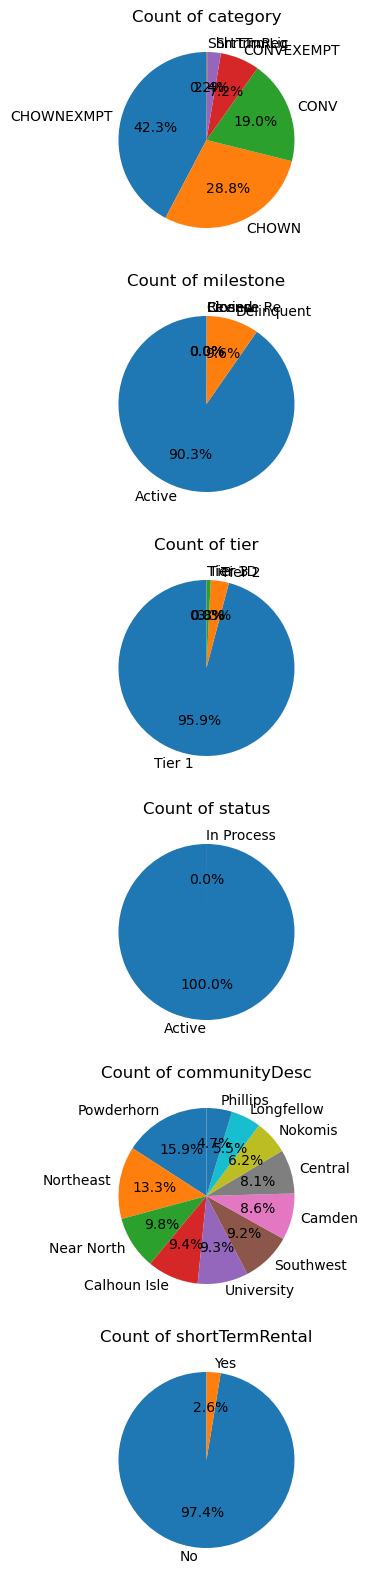

In [24]:
object_cols = ['category', 'milestone', 'tier', 'status','communityDesc','shortTermRental']
plot_object(df_cleaned, object_cols)

Taken form the application form:
- CONV: Conversion: have to pay a $1000 fee
- CONVEXMPT: Conversion but exempt from paying the fee
- CHOWN: Change of Ownership: have to pay a $450 pay
- CHOWNEXEMPT: Change of Owership Exemption from fee
- 
- 